In [2]:
# ------------------------------------------------------------
# Northwestern University 
# Predict 422
# W7 Part2 Classify Dog and Cat images using CNN
# Author Christopher Fiore 
# -------------------------------------------------------------
# S1 Run SetUp Script to Install Packages 
import pandas as pd  # data frame operations  
import sklearn
import plotly
import plotly.graph_objs as go
import time
import numpy as np
import os
import sys
import re # regular expressions
import scipy
import seaborn as sns  # pretty plotting, including heat map
from functools import partial
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Set enviorment varaibles
random_seed=1
#height = 64
#width = 64  

# to make this notebook's output stable across runs
#np.random.seed(random_seed)
#tf.random.set_seed(random_seed)

In [3]:
#S2 Mount Google Drive to Colab Enviorment
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
#S3 Establish working directory

# %cd /content/gdrive/My Drive/NWU_ta/MSDS422_PML_2019/wk7

print('Working Directory')
print(os.getcwd())
work_dir = os.getcwd()
data_dir = work_dir
chp_id = "cnn"

#S3a Define Function to Create CNN - Soure Geron Chap14
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(work_dir, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

def dist_plot(var1, var2, var3):
    tmp_plt=sns.countplot(var1, palette="Blues").set_title(var2)
    tmp_fig = tmp_plt.get_figure()
    tmp_fig.savefig(var3 + ".png", 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25)
    return(tmp_plt)

def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images
#Tensorboard Logs
root_logdir = os.path.join(os.curdir, "tf_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

Working Directory
C:\Users\myl94\OneDrive\Desktop\ds projects\422 exercises\Assignments cnn


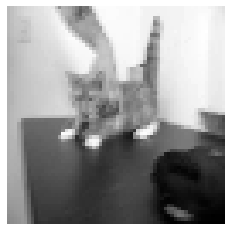

In [5]:
#S5 Load/Import data created from PRD422CD_Prep notebook  
cats_1000_64_64_1 = np.load(data_dir+'./cats_dogs_arrays/cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load(data_dir+'./cats_dogs_arrays/dogs_1000_64_64_1.npy')
scr_12500_64_64_1 = np.load(data_dir+'./cats_dogs_arrays/scr_12500_64_64_1.npy')

# Examine first cat and first dog grayscale images
plot_image(cats_1000_64_64_1[0,:,:,0])

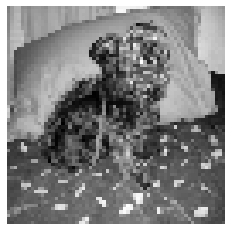

In [6]:

plot_image(dogs_1000_64_64_1[0,:,:,0])

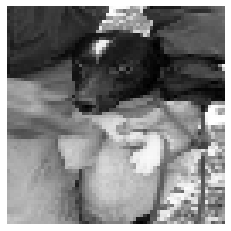

In [7]:
plot_image(scr_12500_64_64_1[0,:,:,0])

In [8]:
#S6 Create modeling dataset - stack cat and dog array
X_cat_dog= np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
#Drop last column in array will add back after scaling process
X_cat_dog=X_cat_dog[:,:,:,-1]
X_cat_dog.shape

#Assign labels
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                            np.ones((1000), dtype = np.int32)), axis = 0)
#S7 Split Train, Validate and Test
X_train, X_test_ds, y_train, y_test_ds= train_test_split(X_cat_dog, y_cat_dog, 
                                                         test_size=0.5, random_state= random_seed)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_ds, y_test_ds, 
                                                    test_size=0.30, random_state = random_seed)
#S8 Scale images/numpy array
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_scr =scr_12500_64_64_1
X_scr_mean = X_scr.mean(axis=0, keepdims=True)
X_scr_std = X_scr.std(axis=0, keepdims=True) + 1e-7
X_scr = (X_scr - X_scr_mean) / X_scr_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

#Review Distribution
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)
print(X_scr.shape)

(1000, 64, 64, 1)
(700, 64, 64, 1)
(300, 64, 64, 1)
(1000,)
(700,)
(300,)
(12500, 64, 64, 1)


C:\Users\myl94\anaconda3\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-4-cb65703f374f>:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  tmp_fig.savefig(var3 + ".png",
<ipython-input-9-24cd8e96b142>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cd_plt_trn.get_figure().show()
C:\Users\myl94\anaconda3\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and pa

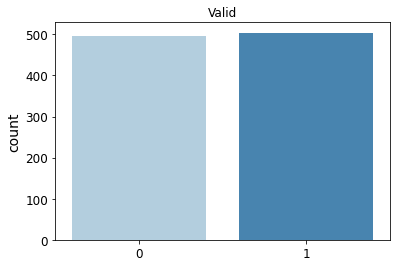

In [9]:
#S9 Check distribtion of test , valid and train
cd_plt_trn=dist_plot(y_train, 'Train', "TrainDistCatDog")
cd_plt_trn.get_figure().show()

cd_plt_tst=dist_plot(y_test, 'Test', "TestDistCatDog")
cd_plt_tst.get_figure().show()

cd_plt_vld=dist_plot(y_valid, 'Valid', "ValidDistCatDog")
cd_plt_vld.get_figure().show()

### Model 1

In [41]:
#S10 Compile Model
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='SAME', input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(units=2, activation='softmax'),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [42]:
#S11 Clear and Reset log
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)
#Reset Log Directory
run_logdir = get_run_logdir()

In [ ]:
#S12 Execution with early Stopping
start_time = time.process_time()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint(work_dir+"./tmp/my_keras_model.h5", save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=1, patience=10)
#optimizer = keras.optimizers.Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.9)
n_epochs = 30

model.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])
score = model.evaluate(X_valid, y_valid)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
start_time = time.process_time()

Epoch 1/30
32/32 [==============================] - 9s 279ms/step - loss: 0.7910 - accuracy: 0.4711 - val_loss: 0.6905 - val_accuracy: 0.4986
Epoch 2/30
32/32 [==============================] - 9s 272ms/step - loss: 0.7037 - accuracy: 0.5228 - val_loss: 0.6871 - val_accuracy: 0.5057
Epoch 3/30
32/32 [==============================] - 8s 239ms/step - loss: 0.6986 - accuracy: 0.5396 - val_loss: 0.6852 - val_accuracy: 0.5671
Epoch 4/30
32/32 [==============================] - 7s 217ms/step - loss: 0.7001 - accuracy: 0.4918 - val_loss: 0.6915 - val_accuracy: 0.5271
Epoch 5/30
32/32 [==============================] - 7s 213ms/step - loss: 0.6875 - accuracy: 0.5406 - val_loss: 0.6799 - val_accuracy: 0.5314
Epoch 6/30
32/32 [==============================] - 7s 223ms/step - loss: 0.6865 - accuracy: 0.5353 - val_loss: 0.6775 - val_accuracy: 0.5700
Epoch 7/30
32/32 [==============================] - 7s 233ms/step - loss: 0.6764 - accuracy: 0.5979 - val_loss: 0.6602 - val_accuracy: 0.6029
Epoch 

In [40]:
#Model Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

Saving figure keras_learning_curves_plot


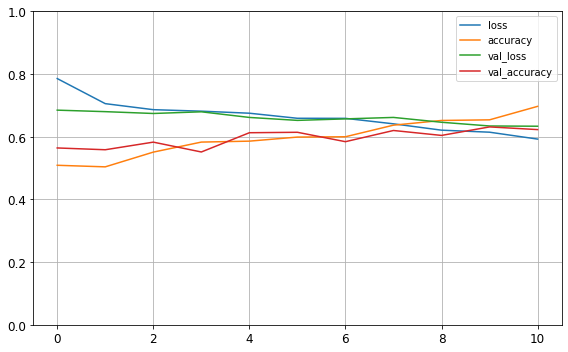

In [13]:
#S13 View History
history.params
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [14]:
#S14 Create Predicited Probabilties
y_proba = model.predict(X_valid)
y_proba.round(2)

array([[0.44],
       [0.5 ],
       [0.45],
       [0.59],
       [0.49],
       [0.38],
       [0.56],
       [0.43],
       [0.43],
       [0.47],
       [0.62],
       [0.8 ],
       [0.69],
       [0.6 ],
       [0.47],
       [0.4 ],
       [0.49],
       [0.57],
       [0.71],
       [0.79],
       [0.78],
       [0.74],
       [0.57],
       [0.74],
       [0.6 ],
       [0.66],
       [0.39],
       [0.65],
       [0.77],
       [0.71],
       [0.43],
       [0.41],
       [0.54],
       [0.56],
       [0.55],
       [0.72],
       [0.65],
       [0.47],
       [0.51],
       [0.54],
       [0.71],
       [0.56],
       [0.57],
       [0.57],
       [0.72],
       [0.65],
       [0.4 ],
       [0.66],
       [0.48],
       [0.47],
       [0.63],
       [0.42],
       [0.67],
       [0.46],
       [0.74],
       [0.63],
       [0.75],
       [0.48],
       [0.46],
       [0.39],
       [0.34],
       [0.55],
       [0.44],
       [0.69],
       [0.46],
       [0.43],
       [0.

In [15]:
#Create Predicted Value
y_pred =(model.predict(X_valid) > 0.5).astype("int32")

In [16]:
#View actual to predicted
print("Predicted classes:", np.reshape(y_pred[:20], (1, 20)))
print("Actual classes:   ", y_valid[:20])

Predicted classes: [[0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1]]
Actual classes:    [0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1]


In [17]:
#Create Predicited Probabilties on Kaggle Test file
y_proba_scr = model.predict(X_scr)
y_proba_scr.round(2)


array([[0.6 ],
       [0.64],
       [0.38],
       ...,
       [0.37],
       [0.65],
       [0.34]], dtype=float32)

In [18]:
#Score Predicted Value
y_pred_scr =(model.predict(X_scr) > 0.5).astype("int32")

In [19]:
#View Score predicted
print("Predicted classes:", np.reshape(y_pred_scr[:20], (1, 20)))

Predicted classes: [[1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1]]


### model 2

In [20]:
#S10 Compile Model
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='SAME', input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(units=2, activation='softmax'),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [21]:
#S11 Clear and Reset log
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)
#Reset Log Directory
run_logdir = get_run_logdir()

In [22]:
#Model Summary 
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [23]:
#S12 Execution with early Stopping
start_time = time.process_time()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint(work_dir+"./tmp/my_keras_model2.h5", save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=1, patience=10)
#optimizer = keras.optimizers.Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.9)
n_epochs = 30

model_2.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
history_2 = model_2.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])
score = model_2.evaluate(X_valid, y_valid)
X_new = X_test[:10] # pretend we have new images
y_pred = model_2.predict(X_new)
start_time = time.process_time()

Epoch 1/30
32/32 [==============================] - 11s 321ms/step - loss: 0.7045 - accuracy: 0.5093 - val_loss: 0.6898 - val_accuracy: 0.5743
Epoch 2/30
32/32 [==============================] - 9s 278ms/step - loss: 0.6941 - accuracy: 0.5432 - val_loss: 0.6840 - val_accuracy: 0.5843
Epoch 3/30
32/32 [==============================] - 9s 271ms/step - loss: 0.6894 - accuracy: 0.5492 - val_loss: 0.6784 - val_accuracy: 0.6229
Epoch 4/30
32/32 [==============================] - 9s 298ms/step - loss: 0.6717 - accuracy: 0.5840 - val_loss: 0.6787 - val_accuracy: 0.6086
Epoch 5/30
32/32 [==============================] - 9s 283ms/step - loss: 0.6662 - accuracy: 0.6162 - val_loss: 0.6590 - val_accuracy: 0.6143
Epoch 6/30
32/32 [==============================] - 10s 305ms/step - loss: 0.6573 - accuracy: 0.5995 - val_loss: 0.6510 - val_accuracy: 0.6657
Epoch 7/30
32/32 [==============================] - 9s 271ms/step - loss: 0.6513 - accuracy: 0.6240 - val_loss: 0.6451 - val_accuracy: 0.6500
Epoc

Saving figure keras_learning_curves_plot


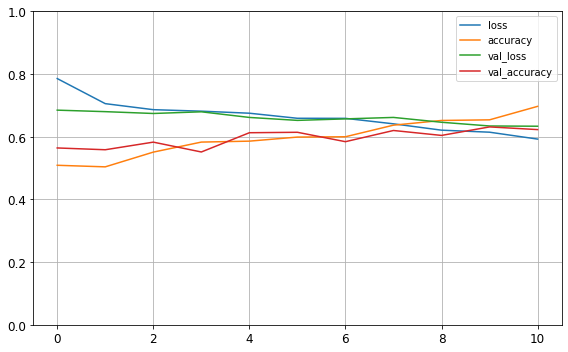

In [24]:
#S13 View History
history_2.params
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [25]:
#S14 Create Predicited Probabilties
y_proba_2 = model_2.predict(X_valid)
y_proba_2.round(2)

array([[0.39],
       [0.37],
       [0.38],
       [0.58],
       [0.41],
       [0.29],
       [0.53],
       [0.36],
       [0.3 ],
       [0.5 ],
       [0.58],
       [0.7 ],
       [0.64],
       [0.58],
       [0.4 ],
       [0.29],
       [0.49],
       [0.59],
       [0.54],
       [0.8 ],
       [0.83],
       [0.73],
       [0.53],
       [0.74],
       [0.67],
       [0.69],
       [0.26],
       [0.61],
       [0.72],
       [0.6 ],
       [0.41],
       [0.32],
       [0.57],
       [0.53],
       [0.38],
       [0.66],
       [0.59],
       [0.34],
       [0.51],
       [0.52],
       [0.69],
       [0.5 ],
       [0.55],
       [0.46],
       [0.68],
       [0.64],
       [0.32],
       [0.64],
       [0.48],
       [0.45],
       [0.57],
       [0.39],
       [0.65],
       [0.44],
       [0.72],
       [0.66],
       [0.76],
       [0.46],
       [0.4 ],
       [0.37],
       [0.26],
       [0.61],
       [0.44],
       [0.67],
       [0.56],
       [0.4 ],
       [0.

In [26]:
#Create Predicted Value
y_pred_2 =(model_2.predict(X_valid) > 0.5).astype("int32")

In [27]:
#View actual to predicted
print("Predicted classes:", np.reshape(y_pred_2[:20], (1, 20)))
print("Actual classes:   ", y_valid[:20])

Predicted classes: [[0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1]]
Actual classes:    [0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1]


In [28]:
#Create Predicited Probabilties on Kaggle Test file
y_proba_scr_2 = model_2.predict(X_scr)
y_proba_scr_2.round(2)


array([[0.59],
       [0.69],
       [0.47],
       ...,
       [0.31],
       [0.66],
       [0.31]], dtype=float32)

In [29]:
#Score Predicted Value
y_pred_scr_2 =(model_2.predict(X_scr) > 0.5).astype("int32")

In [30]:
#View Score predicted
print("Predicted classes:", np.reshape(y_pred_scr_2[:20], (1, 20)))

Predicted classes: [[1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0]]


### model 3

In [31]:
#S10 Compile Model
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='SAME', input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(units=2, activation='softmax'),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [32]:
#Model Summary 
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [33]:
#S12 Execution with early Stopping
start_time = time.process_time()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint(work_dir+"./tmp/my_keras_model3.h5", save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=1, patience=10)
#optimizer = keras.optimizers.Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.9)
n_epochs = 30

model_3.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
history_3 = model_3.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])
score = model_3.evaluate(X_valid, y_valid)
X_new = X_test[:10] # pretend we have new images
y_pred = model_3.predict(X_new)
start_time = time.process_time()

Epoch 1/30
32/32 [==============================] - 16s 474ms/step - loss: 0.6953 - accuracy: 0.5178 - val_loss: 0.6932 - val_accuracy: 0.5029
Epoch 2/30
32/32 [==============================] - 13s 417ms/step - loss: 0.6936 - accuracy: 0.5106 - val_loss: 0.6907 - val_accuracy: 0.4971
Epoch 3/30
32/32 [==============================] - 13s 418ms/step - loss: 0.6940 - accuracy: 0.4954 - val_loss: 0.6862 - val_accuracy: 0.5029
Epoch 4/30
32/32 [==============================] - 13s 419ms/step - loss: 0.6879 - accuracy: 0.5409 - val_loss: 0.6811 - val_accuracy: 0.6086
Epoch 5/30
32/32 [==============================] - 14s 427ms/step - loss: 0.6764 - accuracy: 0.5893 - val_loss: 0.6877 - val_accuracy: 0.5129
Epoch 6/30
32/32 [==============================] - 14s 452ms/step - loss: 0.6769 - accuracy: 0.5757 - val_loss: 0.6689 - val_accuracy: 0.5886
Epoch 7/30
32/32 [==============================] - 15s 455ms/step - loss: 0.6654 - accuracy: 0.5881 - val_loss: 0.6518 - val_accuracy: 0.6371

Saving figure keras_learning_curves_plot


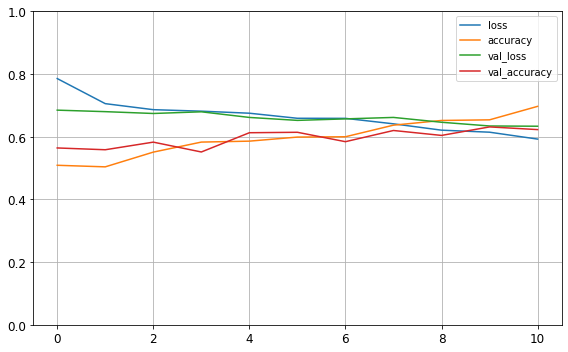

In [34]:
#S13 View History
history_3.params
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [35]:
#S14 Create Predicited Probabilties
y_proba_3 = model_3.predict(X_valid)
y_proba_3.round(2)

array([[0.44],
       [0.39],
       [0.45],
       [0.53],
       [0.41],
       [0.32],
       [0.56],
       [0.4 ],
       [0.39],
       [0.49],
       [0.55],
       [0.38],
       [0.52],
       [0.54],
       [0.38],
       [0.31],
       [0.47],
       [0.47],
       [0.45],
       [0.7 ],
       [0.77],
       [0.67],
       [0.45],
       [0.66],
       [0.61],
       [0.66],
       [0.3 ],
       [0.47],
       [0.63],
       [0.62],
       [0.38],
       [0.41],
       [0.6 ],
       [0.5 ],
       [0.36],
       [0.51],
       [0.43],
       [0.45],
       [0.52],
       [0.53],
       [0.67],
       [0.41],
       [0.54],
       [0.42],
       [0.58],
       [0.56],
       [0.34],
       [0.61],
       [0.45],
       [0.53],
       [0.53],
       [0.43],
       [0.54],
       [0.41],
       [0.63],
       [0.59],
       [0.68],
       [0.4 ],
       [0.42],
       [0.44],
       [0.35],
       [0.5 ],
       [0.46],
       [0.65],
       [0.62],
       [0.4 ],
       [0.

In [36]:
#Create Predicted Value
y_pred_3 =(model_3.predict(X_valid) > 0.5).astype("int32")

In [37]:
#View actual to predicted
print("Predicted classes:", np.reshape(y_pred_3[:20], (1, 20)))
print("Actual classes:   ", y_valid[:20])

Predicted classes: [[0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1]]
Actual classes:    [0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1]


In [38]:
#Create Predicited Probabilties on Kaggle Test file
y_proba_scr_3 = model_3.predict(X_scr)
y_proba_scr_3.round(2)

array([[0.44],
       [0.56],
       [0.57],
       ...,
       [0.33],
       [0.65],
       [0.38]], dtype=float32)

In [39]:
#Score Predicted Value
y_pred_scr_3 =(model_3.predict(X_scr) > 0.5).astype("int32")

In [40]:
#View Score predicted
print("Predicted classes:", np.reshape(y_pred_scr_3[:20], (1, 20)))

Predicted classes: [[0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0]]


### model 4

In [52]:
#S10 Compile Model
model_4 = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='SAME', input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(units=2, activation='softmax'),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [53]:
#Model Summary 
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 64)        3200      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 256)        

In [54]:
#S12 Execution with early Stopping
start_time = time.process_time()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint(work_dir+"./tmp/my_keras_model4.h5", save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(monitor='loss', mode ='min', min_delta=1, patience=10)
#optimizer = keras.optimizers.Nadam(lr=1e-4, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.RMSprop(lr=1e-4, rho=0.9)
n_epochs = 30

model_4.compile(loss='binary_crossentropy', optimizer =optimizer, metrics=["accuracy"])
history_4 = model_4.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])
score = model_4.evaluate(X_valid, y_valid)
X_new = X_test[:10] # pretend we have new images
y_pred = model_4.predict(X_new)
start_time = time.process_time()

Epoch 1/30
32/32 [==============================] - 39s 1s/step - loss: 0.6936 - accuracy: 0.4991 - val_loss: 0.6933 - val_accuracy: 0.5029
Epoch 2/30
32/32 [==============================] - 36s 1s/step - loss: 0.6933 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 36s 1s/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6919 - val_accuracy: 0.4971
Epoch 4/30
32/32 [==============================] - 35s 1s/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6921 - val_accuracy: 0.4971
Epoch 5/30
32/32 [==============================] - 35s 1s/step - loss: 0.6884 - accuracy: 0.5385 - val_loss: 0.6787 - val_accuracy: 0.5157
Epoch 6/30
32/32 [==============================] - 35s 1s/step - loss: 0.6939 - accuracy: 0.5203 - val_loss: 0.6926 - val_accuracy: 0.5014
Epoch 7/30
32/32 [==============================] - 35s 1s/step - loss: 0.6947 - accuracy: 0.5138 - val_loss: 0.6794 - val_accuracy: 0.6043
Epoch 8/30
32/32 [==

Saving figure keras_learning_curves_plot


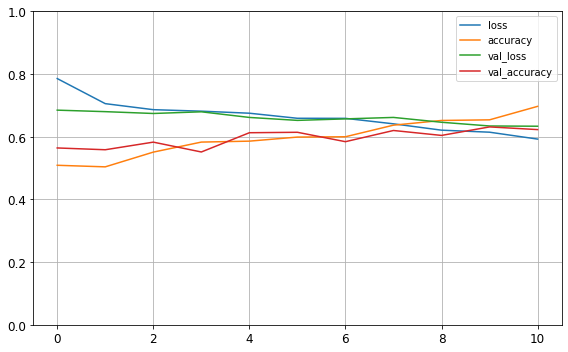

In [55]:
#S13 View History
history_4.params
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()
#Saving figure

In [56]:
#S14 Create Predicited Probabilties
y_proba_4 = model_4.predict(X_valid)
y_proba_4.round(2)

array([[0.46],
       [0.4 ],
       [0.57],
       [0.54],
       [0.56],
       [0.42],
       [0.5 ],
       [0.4 ],
       [0.64],
       [0.45],
       [0.58],
       [0.42],
       [0.47],
       [0.46],
       [0.43],
       [0.38],
       [0.62],
       [0.42],
       [0.65],
       [0.78],
       [0.85],
       [0.77],
       [0.46],
       [0.63],
       [0.69],
       [0.7 ],
       [0.36],
       [0.59],
       [0.66],
       [0.7 ],
       [0.57],
       [0.43],
       [0.6 ],
       [0.7 ],
       [0.37],
       [0.54],
       [0.59],
       [0.64],
       [0.67],
       [0.57],
       [0.79],
       [0.47],
       [0.59],
       [0.47],
       [0.73],
       [0.57],
       [0.39],
       [0.65],
       [0.45],
       [0.6 ],
       [0.57],
       [0.42],
       [0.59],
       [0.45],
       [0.73],
       [0.65],
       [0.78],
       [0.67],
       [0.4 ],
       [0.5 ],
       [0.37],
       [0.65],
       [0.47],
       [0.74],
       [0.71],
       [0.42],
       [0.

In [57]:
#Create Predicted Value
y_pred_4 =(model_4.predict(X_valid) > 0.5).astype("int32")

In [58]:
#View actual to predicted
print("Predicted classes:", np.reshape(y_pred_4[:20], (1, 20)))
print("Actual classes:   ", y_valid[:20])

Predicted classes: [[0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1]]
Actual classes:    [0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1]


In [59]:
#Create Predicited Probabilties on Kaggle Test file
y_proba_scr_4 = model_4.predict(X_scr)
y_proba_scr_4.round(2)

array([[0.53],
       [0.65],
       [0.65],
       ...,
       [0.41],
       [0.66],
       [0.44]], dtype=float32)

In [60]:
#Score Predicted Value
y_pred_scr_4 =(model_4.predict(X_scr) > 0.5).astype("int32")

In [61]:
#View Score predicted
print("Predicted classes:", np.reshape(y_pred_scr_4[:20], (1, 20)))

Predicted classes: [[1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0]]


In [62]:
#Kaggle Submission
scr_df=pd.DataFrame(y_pred_scr)
scr_df.index.name = 'id'
scr_df.columns = ['label']
print(scr_df)
#Export to Excel
scr_df.to_excel("scr.xlsx") 

       label
id          
0          1
1          1
2          0
3          1
4          0
...      ...
12495      1
12496      0
12497      0
12498      1
12499      0

[12500 rows x 1 columns]


For this week's assignment, I was concentrated on building CNN model and figure out what factors will cause the accuracy of the model. I created 4 different models. At first I have tried to add multiple layers into each model, the first layer I only add one layer with filter = 64. The second model, there are two layers,one layer with filer = 64, and one filter with 128. The third model, I have three layers, they are filer = 64, filter = 128 and filter =256. and the fouth model, there are four layers, they are filter = 64, filter = 128, filter = 215, and filter = 512. With more layers in the model, the more accuracy is the model. Another thing I would like to edit is the epoch number, I think the more epochs number, them more accuracy is. 